In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import math

# EDA Data Analysis

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)

(43152, 11)


In [3]:
df.drop(columns="Id",axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43152 non-null  float64
 1   cut      43152 non-null  object 
 2   color    43152 non-null  object 
 3   clarity  43152 non-null  object 
 4   depth    43152 non-null  float64
 5   table    43152 non-null  float64
 6   price    43152 non-null  int64  
 7   x        43152 non-null  float64
 8   y        43152 non-null  float64
 9   z        43152 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


In [4]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


# Dealing with Null values and duplicates values

In [5]:
df.isnull().sum() # to check Null values

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)

97


In [7]:
df.describe()

,carat,depth,table,price,x,y,z
count,43055.000000,43055.000000,43055.000000,43055.000000,43055.000000,43055.000000,43055.000000
mean,0.797752,61.746373,57.459798,3930.016235,5.731555,5.735063,3.538528
std,0.473198,1.435066,2.234325,3984.939986,1.120732,1.148389,0.707922
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,948.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5312.500000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


# Visualizations

## Exploring skewed in dataset 

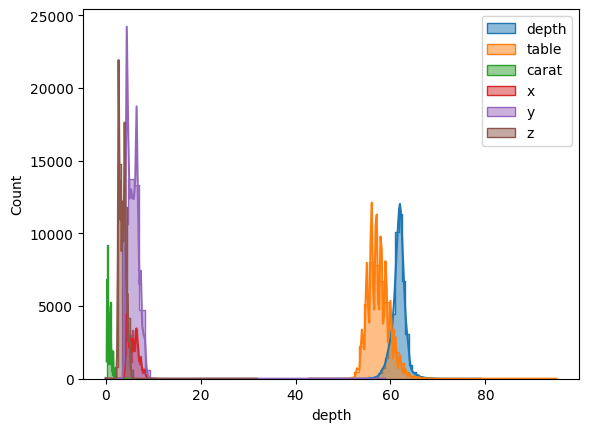

In [8]:
numerical_columns = ['depth', 'table', 'carat', 'x', 'y', 'z']  
for column in numerical_columns:
    sns.histplot(df[column], bins=50, kde=True, element='step', label=column)
plt.legend()
plt.show()

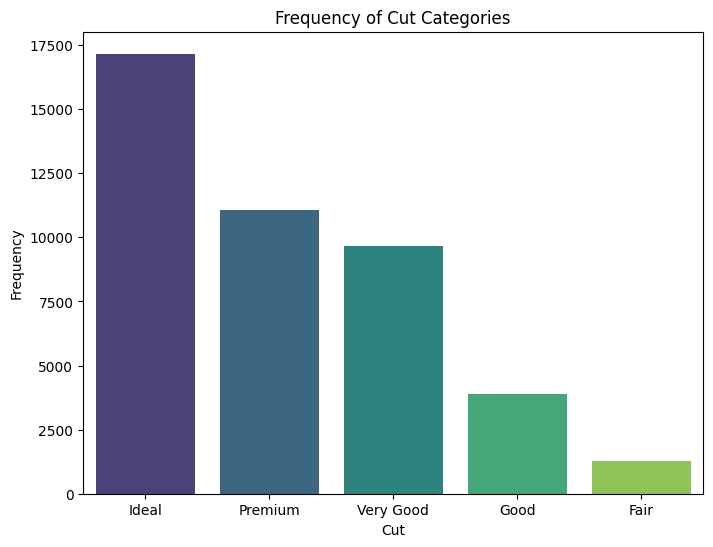

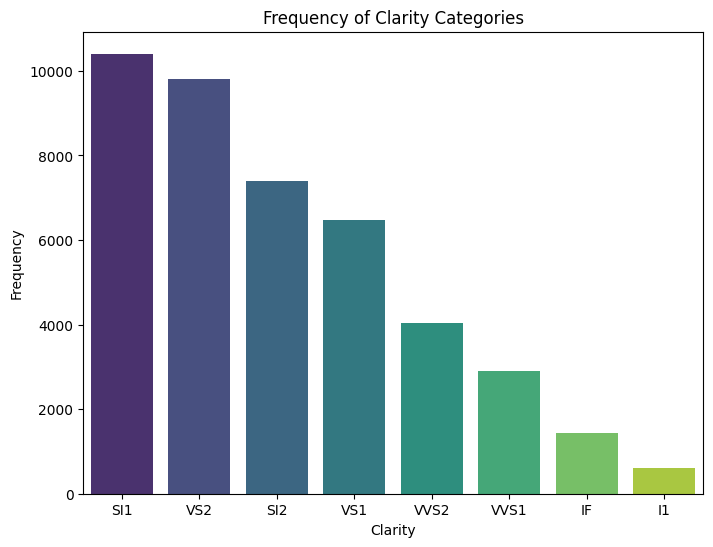

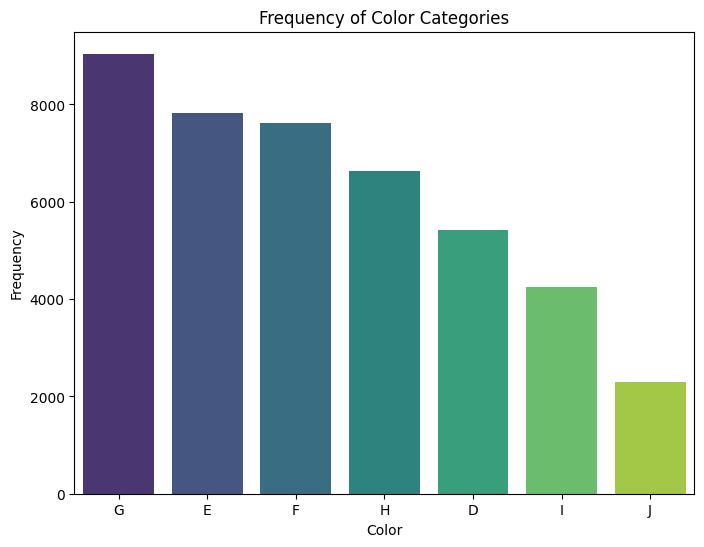

In [9]:
categorical_columns = ['cut', 'clarity', 'color']

for column in categorical_columns:
    column_counts = df[column].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=column_counts.index, y=column_counts.values, palette='viridis')
    plt.title(f'Frequency of {column.title()} Categories')
    plt.xlabel(column.title())
    plt.ylabel('Frequency')
    plt.show()

# Check Correlation between each feature and Price

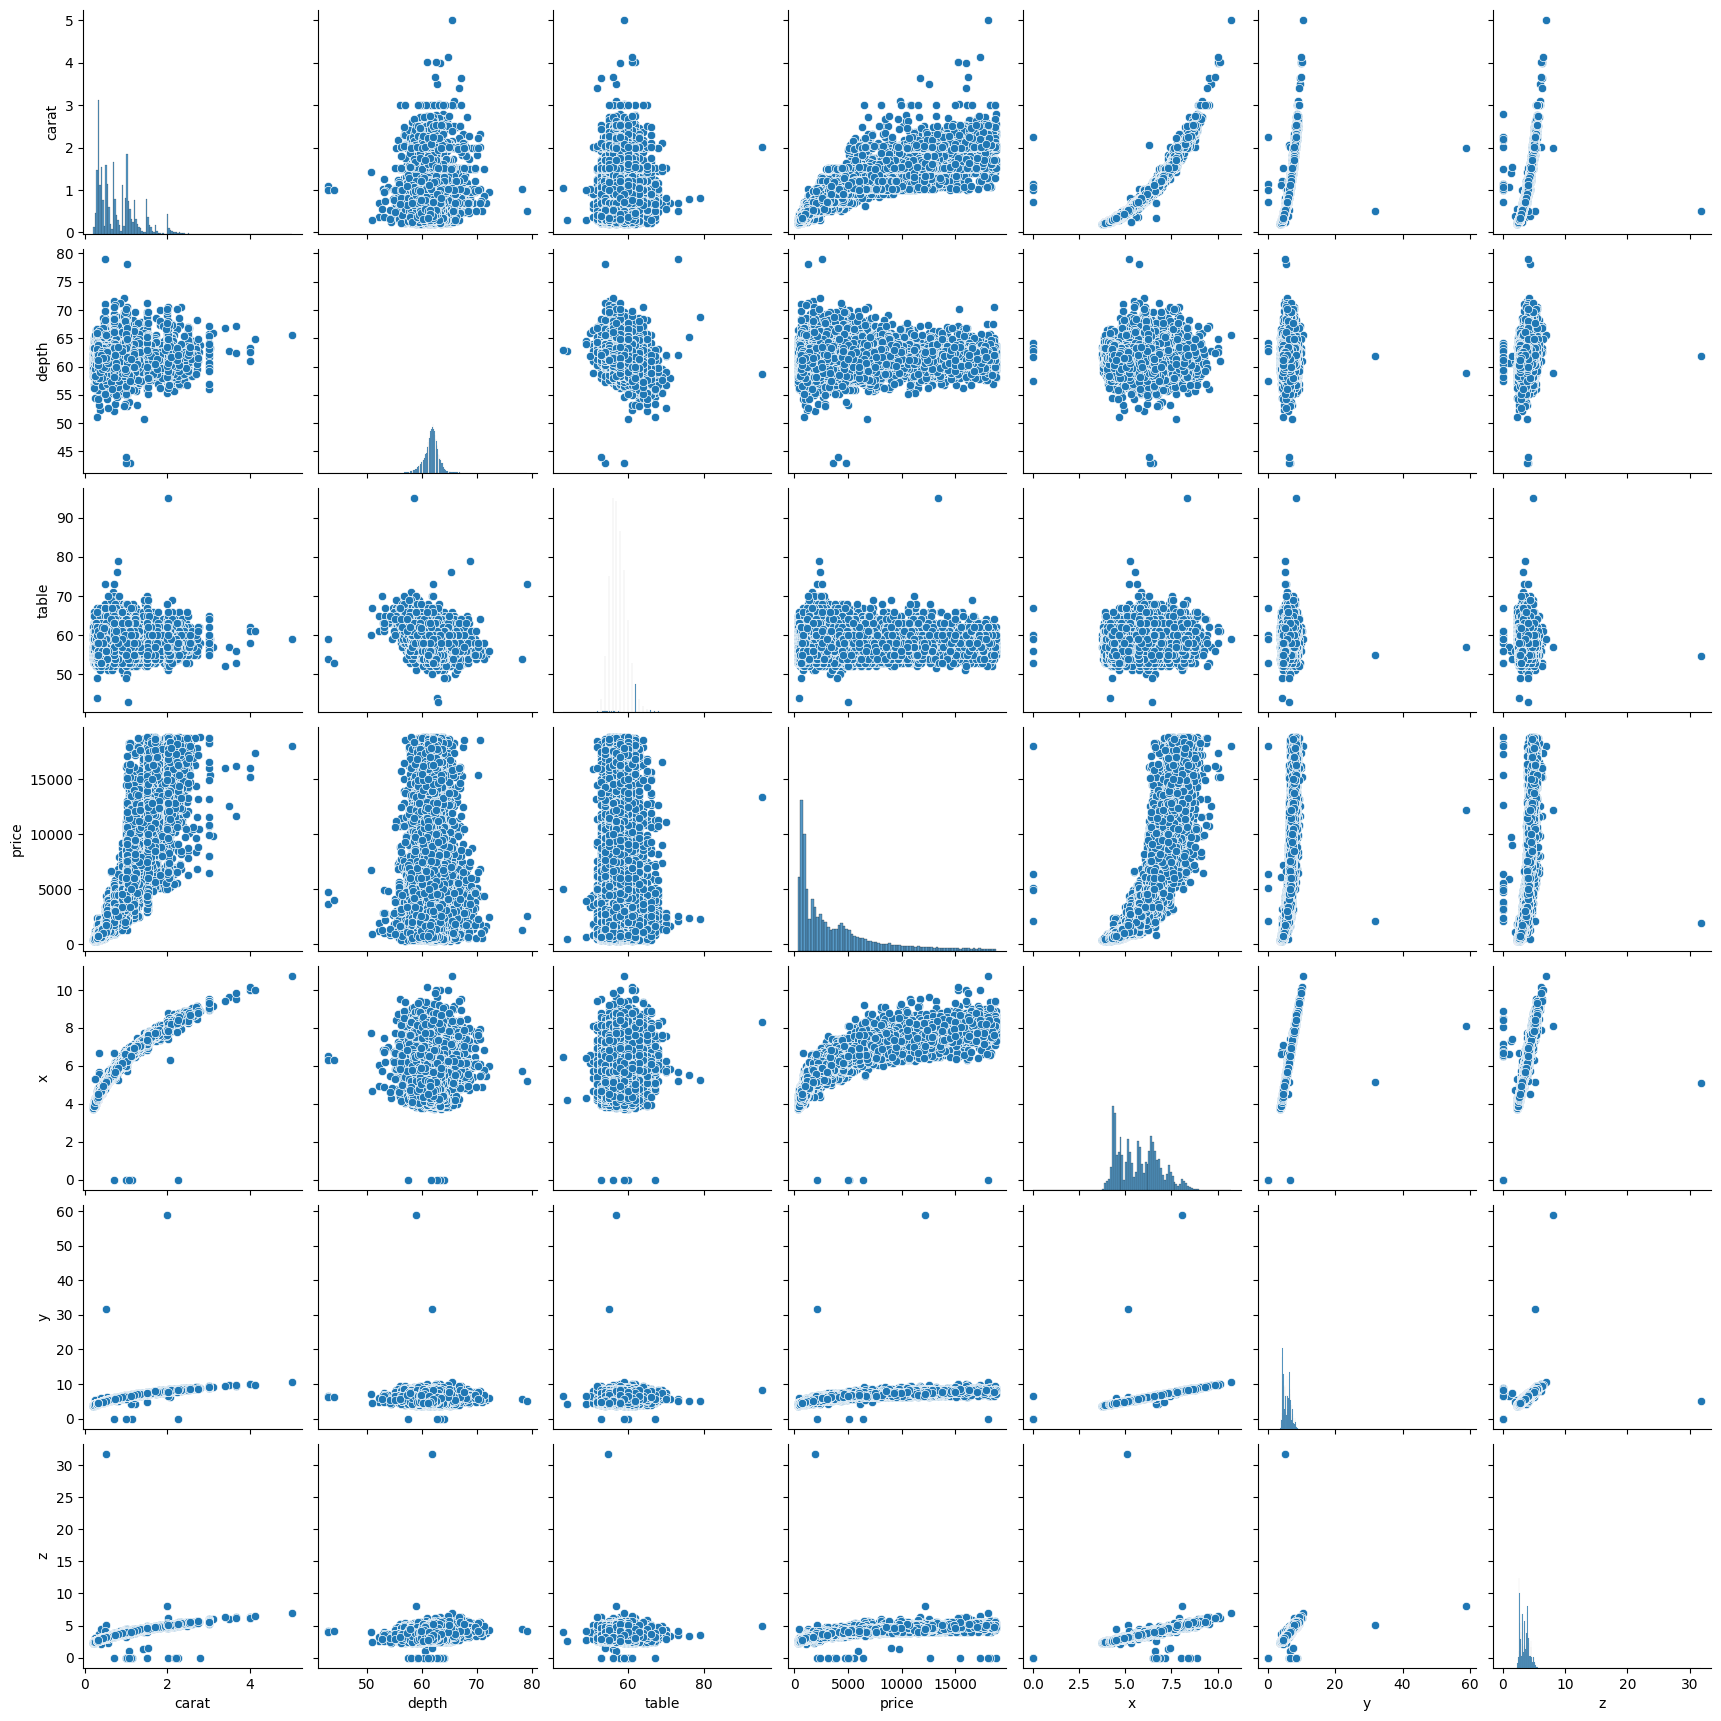

In [10]:
sns.pairplot(data=df)
plt.show()

# Check outliers for dataset

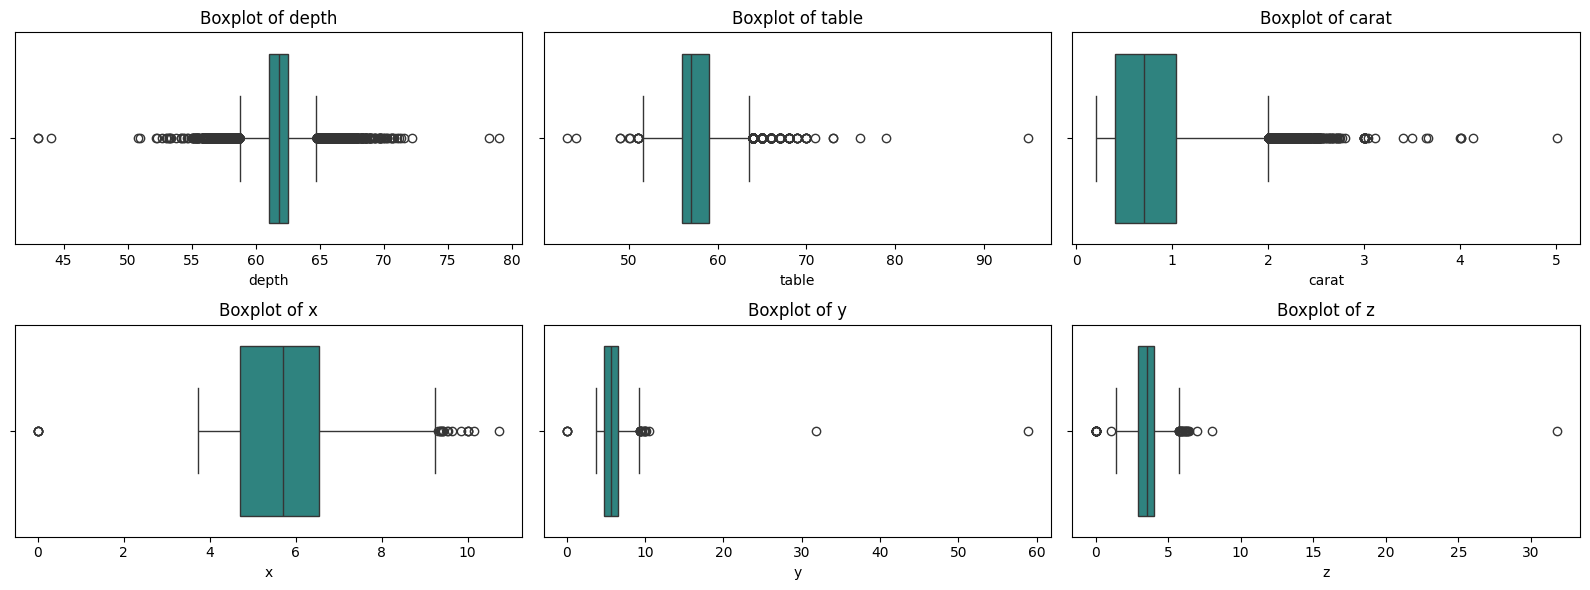

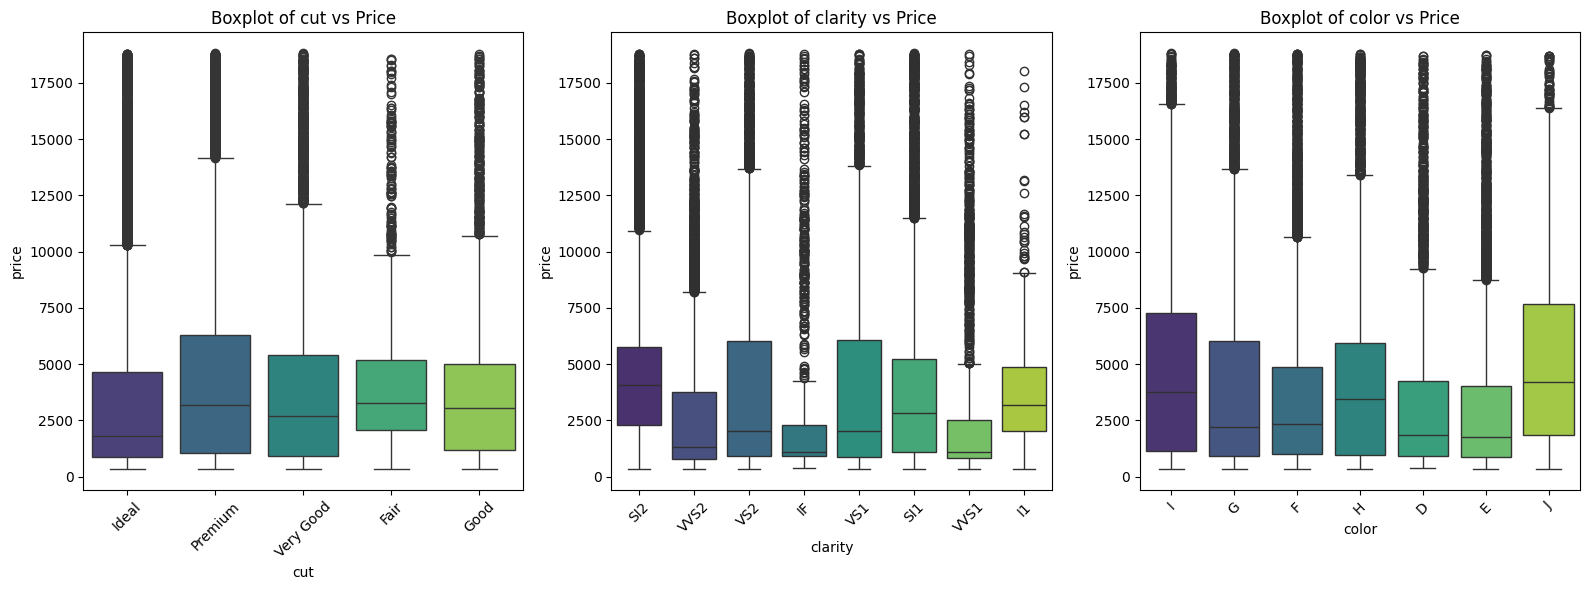

In [11]:
numerical_columns = ['depth', 'table', 'carat', 'x', 'y', 'z']
categorical_columns = ['cut', 'clarity', 'color']

plt.figure(figsize=(16, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=column, data=df, palette="viridis")
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=column, y='price', data=df, palette="viridis")
    plt.title(f'Boxplot of {column} vs Price')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Exploring correlation between numerical values

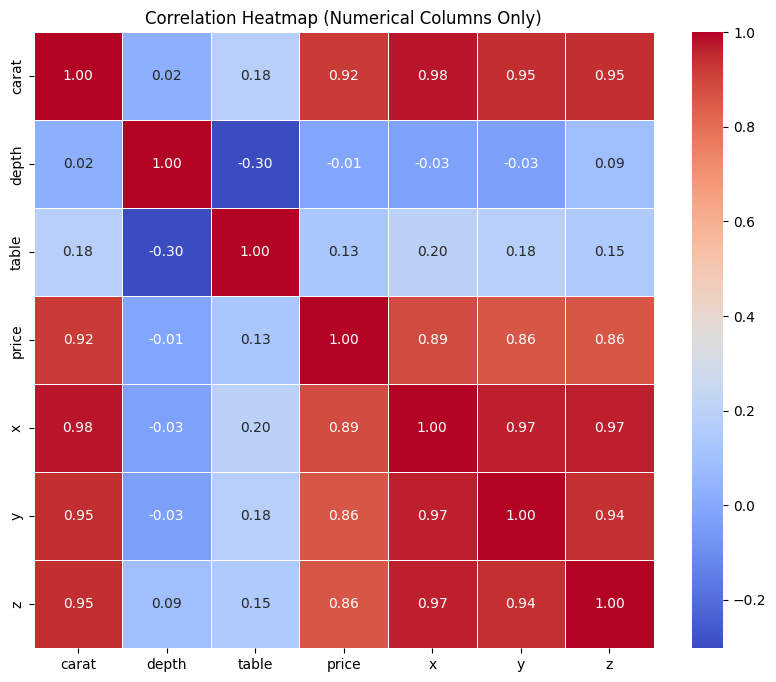

In [12]:
numerical_corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Columns Only)')
plt.show()

# Feature Engineering

In [13]:
df["volume"] = df["x"] * df['y'] * df['z']
df['denisty'] = df['carat'] * df["volume"]
df.drop(columns=['x', 'y', 'z'],axis=1,inplace=True)

In [14]:
df_features = df.drop(columns='price')
df_labels=df['price']

# Data Preparation for Machine Learning model

In [15]:
def encode_categorical_columns(df):
    category_mapping = {}
    encoded_df = df.copy()
    
    categorical_columns = ['cut', 'color', 'clarity']
    for col in categorical_columns:
        encoder = LabelEncoder()
        encoded_df[col] = encoder.fit_transform(df[col])
        category_mapping[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    
    return encoded_df, category_mapping

def decode_categorical_columns(df, encoders):
    decoded_df = df.copy()
    
    for col, encoder in encoders.items():
        category_mapping = {category:num  for category, num in encoder.items()}
        decoded_df[col] = decoded_df[col].map(category_mapping)
    
    return decoded_df

def ScaleNumericalColumns(df):
    
    numerical_columns = ['cut', 'color', 'clarity', 'volume', 'denisty', 'depth', 'table', 'carat']  
    trans = RobustScaler()
    df[numerical_columns] = trans.fit_transform(df[numerical_columns])
    return df

In [16]:
transformed_data_encoding_df, encoders = encode_categorical_columns(df_features)
transformed_data_df = ScaleNumericalColumns(transformed_data_encoding_df)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(transformed_data_df,df_labels, test_size=0.2, random_state=42)

# Modeling Machine Learning

In [18]:
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

# Evaluation in model

In [19]:
y_pred = gb_regressor.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred, squared=True))
print("RMSE on Train Set:", rmse)

RMSE on Train Set: 675.7372169643857


# Fine Tuning for Hyperparameters

In [20]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

# Extract the best model from grid search

In [21]:
best_gb_model = grid_search.best_estimator_
best_gb_model.fit(X_train, y_train)
print("Best Parameters after Grid Search:", grid_search.best_params_)

Best Parameters after Grid Search: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


# Exploring each feature importance in dataset

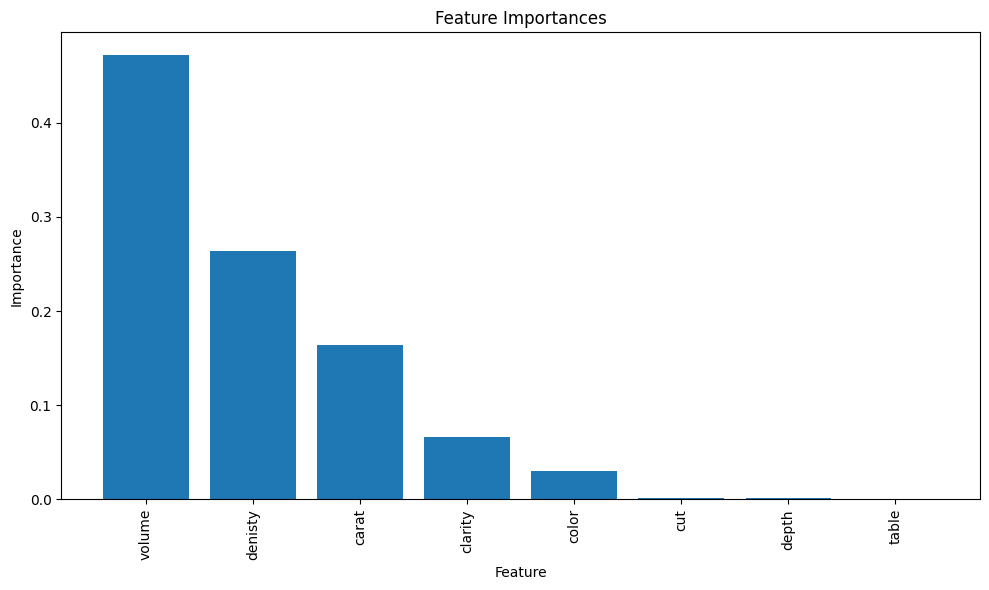

In [22]:
feature_importances = best_gb_model.feature_importances_
feature_names = df_features.columns

indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(df_features.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(df_features.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()  

# The Final Evaluation using the best model

In [23]:
# Make predictions on the test set
y_pred = best_gb_model.predict(X_test)

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred, squared=True))

print("Best Parameters after Grid Search:", grid_search.best_params_)
print("RMSE on Test Set:", rmse)

Best Parameters after Grid Search: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
RMSE on Test Set: 546.1143215592824


# Submission code

In [24]:
test_data = pd.read_csv('test.csv')
Id_column = test_data.drop(['carat', 'cut', 'color', 'clarity', 'depth', 'table','x','y','z'], axis=1)
test_data["volume"] = test_data["x"] * test_data['y'] * test_data['z']
test_data['denisty'] = test_data['carat'] * test_data["volume"]
test_data.drop(columns=['x', 'y', 'z'],axis=1,inplace=True)
test_data.drop('Id', axis=1, inplace=True)
transformed_encoded = decode_categorical_columns(test_data, encoders)
data_scaling = ScaleNumericalColumns(transformed_encoded)

In [25]:
diamond_prediction = best_gb_model.predict(data_scaling)
diamond_prediction_df = pd.DataFrame(diamond_prediction, columns=['price'])
Submission_file = pd.concat([Id_column, diamond_prediction_df], axis=1)
Submission_file.to_csv("Submission.csv", index=None)

# The End
### By Mohamed Adel and  Shahed Hisham